In [3]:
import os
import time
import collections

In [4]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.linear_model import LinearRegression

In [5]:
from utils.envs import TradingEnv9
from utils.td3 import Agent, DropoutAgent
from utils.pred import Predictor, DropoutPredictor
from utils.utilities import fetch_data, live_plot, get_indices

In [6]:
from utils.env_norm import TradingEnvNorm
from utils.env_max_norm import TradingEnvMaxNorm

In [7]:
import warnings

warnings.simplefilter('ignore')

In [8]:
%matplotlib inline

---

In [9]:
REPORT = 100
SEED = 42

In [10]:
#env_name = 'TradingEnv9'
env_name = 'TradingEnvMaxNorm'
db_name = './data/HistoricalPriceData.db'

In [11]:
torch.manual_seed(SEED)
np.random.seed(SEED)

In [12]:
if not os.path.exists('./models'):
    os.makedirs('./models')
if not os.path.exists('./models/all_td3'):
    os.makedirs('./models/all_td3')

In [13]:
file_name = f'TD3_{env_name}_tts_{SEED}'
print(file_name)

TD3_TradingEnvMaxNorm_tts_42


---

In [14]:
data = fetch_data(db_name)

idx = 500
size = 800
tts = 0.75
split = int(tts*size)

size, split, size-split

(800, 600, 200)

In [15]:
for ticker in data:    
    
    data[ticker] = (data[ticker]
        .iloc[idx: idx+size]
        .reset_index(drop=True, inplace=False)
    )
    
set(df.shape[0] for df in data.values())


{800}

##### Create training set

In [16]:
train_dta = {}

for ticker in data:    
    
    train_dta[ticker] = (data[ticker]
        .iloc[:split]
        .reset_index(drop=True, inplace=False)
    )

set(df.shape[0] for df in train_dta.values())


{600}

##### Create testing set

In [17]:
test_dta = {}

for ticker in data:    

    test_dta[ticker] = (data[ticker]
        .iloc[split:]
        .reset_index(drop=True, inplace=False)
    )
    
set(df.shape[0] for df in test_dta.values())


{200}

---
---
---

### Train:

##### Initialize environment

In [18]:
env = eval(f'{env_name}(train_dta)')
env.seed(SEED)

In [19]:
state_dim = np.prod(env.observation_space.shape)
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

##### Initialize agent parameters

In [20]:
buffer_size = 1e6
batch_size = 100

gamma = 0.99
tau = 5e-3
policy_freq = 2
lr = 1e-3
reg = 0 # 1e-3

policy_noise = 0.2
noise_clip = 0.5
expl_noise = 0.15

##### Initialize agent

In [21]:
# Observation space dimension must be modified to include predictor input
agent_state_dim = env.observation_space.shape[0] * (env.observation_space.shape[1]+1)

In [22]:
#agent = Agent(
agent = DropoutAgent(
    state_dim=agent_state_dim, 
    action_dim=action_dim, 
    max_action=max_action,
    eta=lr,
    alpha=reg,
)


##### Initialize predictor model

In [23]:
# Predictor only takes certain parts of the observation space as input  
pred_input = (env.observation_space.shape[0]-1) * (env.observation_space.shape[1]-2)
pred_output = env.action_space.shape[0] - 1

In [24]:
#predictor = Predictor(
predictor = DropoutPredictor(
    input_dim=pred_input, 
    output_dim=pred_output,
    eta=lr,
    alpha=reg,
)


---

##### Initialize training variables 

In [25]:
starting_step = 4e4 # Number of random steps at start

episodes = 3e3 # Number of episodes to train on
total_steps = 0 # Total steps taken so far
training = False # Currently training

In [26]:
positions = env.positions
reward_trace = collections.defaultdict(list)
ep = 1 # Starting episode

In [27]:
size = 250 # How long each episode is
n_obs = env.n_obs

In [31]:
# A distribution of indices is built and drawn from
indices = get_indices(episodes, 1, 349)
indices.min(), indices.max(), indices.shape[0]

(1, 349, 3000)

##### Training:

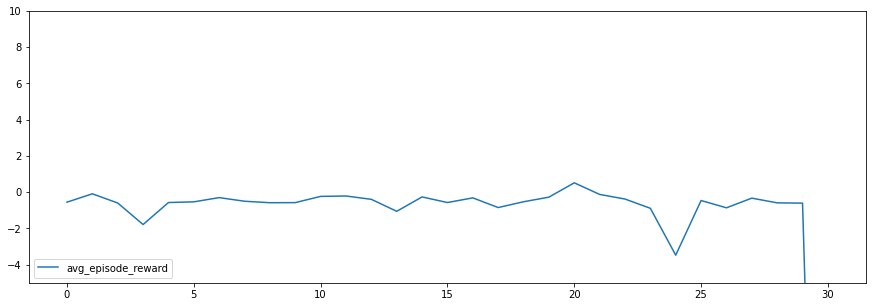

Episode number: 32
Initial index: 278


In [ ]:
for ep in np.arange(ep, episodes+1):    
    
    idx = indices[int(ep)-1]
    print('Episode number:', int(ep))
    print('Initial index:', idx)
    
    env.reset()
    # Manipulate environment:
    env.current_step = idx - 1
    env.scalers = env._configure_scalers_init(env.stocks, idx-1)
    obs = env._next_observation()
        
    done = False
    episode_reward = []
    steps = 0
    
    ##################################################
    
    while not done:    
        
        agent_obs = predictor.predict(obs)
        
        if total_steps == starting_step:
            print('Begin training')
            training = True
            
        if not training:
            action = env.action_space.sample()
        else:
            action = agent.select_action(agent_obs)
            
            if expl_noise != 0:
                noise = np.random.normal(0, expl_noise, size=env.action_space.shape[0])
                action = (action+noise).clip(env.action_space.low, env.action_space.high)
                
        action_fmt = env.format_action(positions, action)
                
        new_obs, reward, done, info = env.step(action_fmt)
        done |= (steps >= size-1)
        
        episode_reward.append(reward)
        predictor.commit(obs, new_obs)        
        
        agent_new_obs = predictor.predict(new_obs)
        agent.replay_buffer.add((agent_obs, agent_new_obs, action, reward, int(done)))
                
        obs = new_obs
        steps += 1
        total_steps += 1
        
    ##################################################
        
    agent.train(steps, batch_size, gamma, tau, policy_noise, noise_clip, policy_freq)
    predictor.train(batch_size)
    
    reward_trace['net_worth_diff'].append(sum(np.array(env.net_worth)-np.array(env.net_worth_long)))
    reward_trace['avg_episode_reward'].append(np.mean(episode_reward))
    reward_trace['sum_episode_reward'].append(sum(episode_reward))
    reward_trace['exploration_noise'].append(round(expl_noise, 9))
    
    ax = live_plot(reward_trace, trace='avg')
    plt.ylim([-5, 10])
    plt.show()
    
    if ep % REPORT == 0:
        
        print('Episode number:', int(ep))
        print('Net-worth difference:', reward_trace['net_worth_diff'][-1])
        print('Average reward:', reward_trace['avg_episode_reward'][-1])
        time.sleep(0.5)
        
        agent.save(
            f'{file_name}_{int(ep)}', 
            './models/all_td3',
        )
        
        predictor.save(
            f'{file_name}_{int(ep)}', 
            './models/all_td3',
        )
        

In [ ]:
ep

##### Plot reward trace

In [37]:
nwd = pd.Series(reward_trace['net_worth_diff'])
nwd = nwd.rolling(window=REPORT, center=True, min_periods=1).mean()

print(np.argmax(nwd)+1, np.argmax(reward_trace['net_worth_diff'])+1)

2152 434


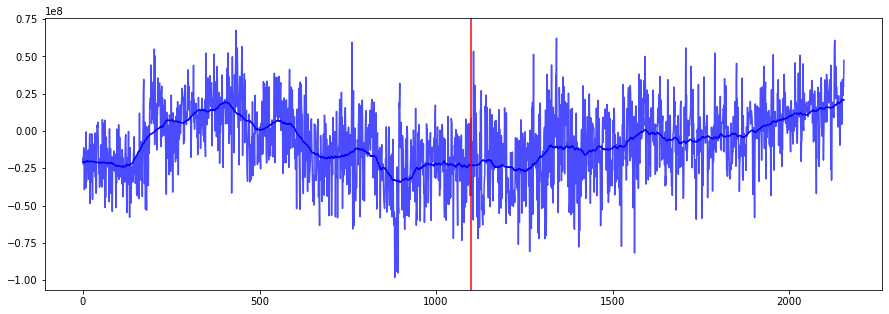

In [38]:
plt.figure(figsize=(15,5))

plt.plot(reward_trace['net_worth_diff'], 'b', alpha=0.7)
plt.plot(nwd, 'b')
plt.axvline(1100, c='r')

plt.show()

In [39]:
lr = LinearRegression()

X = np.arange(1, len(reward_trace['avg_episode_reward'])+1).reshape(-1,1)
y = np.array(reward_trace['avg_episode_reward']).reshape(-1,1)

lr.fit(X, y)

def f(x): return lr.intercept_[0] + np.dot(x.reshape(-1,1), lr.coef_)
print(lr.coef_[0])

[0.00081496]


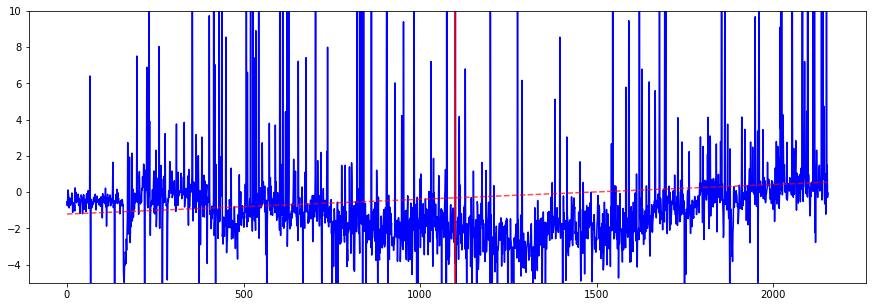

In [40]:
plt.figure(figsize=(15,5))

plt.plot(reward_trace['avg_episode_reward'], 'b')
plt.plot(f(np.arange(len(reward_trace['avg_episode_reward']))), '--r', alpha=0.7)
plt.axvline(1100, c='r')

plt.ylim([-5,10])
plt.show()

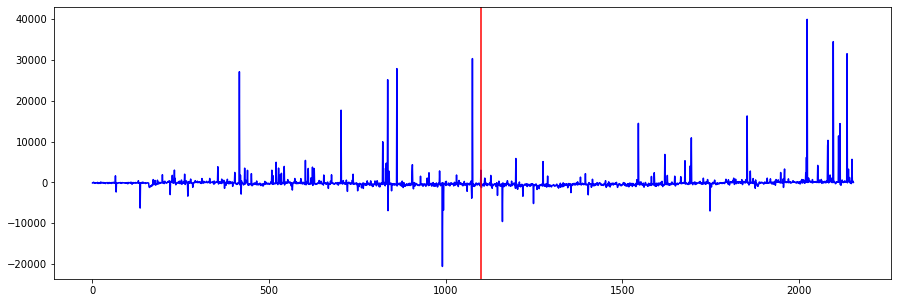

In [41]:
plt.figure(figsize=(15,5))

plt.plot(reward_trace['sum_episode_reward'], 'b')
plt.axvline(1100, c='r')

plt.show()

---
---
---

### Test:

##### Initialize testing environment

In [ ]:
norms = env.normalizers

In [ ]:
norms

In [ ]:
env = eval(f'{env_name}(test_dta)')
env.seed(SEED)

In [ ]:
env.normalizers

In [ ]:
env.normalizers = norms

In [ ]:
env.normalizers

##### Load model

In [ ]:
idx = 3000

In [ ]:
agent_test = Agent(
    state_dim=agent_state_dim, 
    action_dim=action_dim, 
    max_action=max_action,
)

agent_test.load(
    f'{file_name}_{idx}', 
    './models/all_td3',
)


In [ ]:
predictor_test = Predictor(
    input_dim=pred_input, 
    output_dim=pred_output,
)

predictor_test.load(
    f'{file_name}_{idx}', 
    './models/all_td3',
)


##### Testing:

In [ ]:
positions = env.positions
single_reward_trace = collections.defaultdict(list)

In [ ]:
for episode in np.arange(1):

    done = False
    obs = env.reset()

    while not done:
            
        agent_obs = predictor_test.predict(obs)

        action = agent_test.select_action(agent_obs)
        action_fmt = env.format_action(positions, action)

        new_obs, reward, done, info = env.step(action_fmt)
        
        obs = new_obs

        env.render()
    
        single_reward_trace['rewards'].append(reward)
        single_reward_trace['actions'].append(action.squeeze())
        single_reward_trace['net_worth_diff'].append(env.net_worth[-1]-env.net_worth_long[-1])
        single_reward_trace['profit_diff'].append(env.agent_portfolio.profits[-1]-env.long_portfolio.profits[-1])
    

##### Plot reward trace

In [ ]:
rewards = pd.Series(single_reward_trace['rewards']).rolling(window=25, center=True, min_periods=1).mean()

plt.figure(figsize=(15,5))

plt.plot(rewards.values, 'r', alpha=0.9)
plt.plot(single_reward_trace['rewards'], 'b', alpha=0.5)

plt.title('Rewards')
plt.show()

In [ ]:
net_worth = pd.Series(single_reward_trace['net_worth_diff']).rolling(window=25, center=True, min_periods=1).mean()

plt.figure(figsize=(15,5))

plt.plot(net_worth.values, 'r', alpha=0.9)
plt.plot(single_reward_trace['net_worth_diff'], 'b', alpha=0.5)

plt.title('Net-Worth Difference')
plt.show()

In [ ]:
profit = pd.Series(single_reward_trace['profit_diff']).rolling(window=25, center=True, min_periods=1).mean()

plt.figure(figsize=(15,5))

plt.plot(profit.values, 'r', alpha=0.9)
plt.plot(single_reward_trace['profit_diff'], 'b', alpha=0.5)

plt.title('Profit Difference')
plt.show()

In [ ]:
stock = 'aapl'

plt.figure(figsize=(15,7))

actions = np.array(single_reward_trace['actions'])
for action, ticker in zip(actions[:, : env.n_stocks].T, positions):
    a = 0.9 if ticker == stock else 0.1
    plt.plot(action, label=ticker, alpha=a)
    
plt.legend()
plt.show()

---
---
---

### Save:

##### Save

In [ ]:
idx = 3000

In [ ]:
agent.load(
    f'{file_name}_{idx}', 
    './models/all_td3',
)

predictor.load(
    f'{file_name}_{idx}', 
    './models/all_td3',
)


In [ ]:
agent.save(
    file_name, 
    './models',
)

predictor.save(
    file_name, 
    './models',
)


In [ ]:
for item in os.listdir('./models/all_td3'):
    if file_name in str(item):
        os.remove(os.path.join('./models/all_td3', item))
        
print(file_name)